In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [15]:
df = pd.read_csv('./main_parser2.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df = df[df.language != 'Dutch']
df = df[df.error_type != 'S']
df = df[df.error_type != 'SA']
df = df[df.error_type != 'SX']

In [16]:
def concat_dummies(df, dummies):
    for dummy in list(dummies):
        df[dummy] = dummies[dummy]
    return list(dummies)

In [17]:
def create_dummies(df, column, prefix):
    dummies = pd.get_dummies(df[column], prefix=prefix)
    return concat_dummies(df, dummies)

In [18]:
c_first_pos = create_dummies(df, 'correct_trigram_tag_0', 'correct_trigram_tag_0')
c_second_pos = create_dummies(df, 'correct_trigram_tag_1', 'correct_trigram_tag_1')
c_third_pos = create_dummies(df, 'correct_trigram_tag_2', 'correct_trigram_tag_2')
i_first_pos = create_dummies(df, 'incorrect_trigram_tag_0', 'incorrect_trigram_tag_0')
i_second_pos = create_dummies(df, 'incorrect_trigram_tag_1', 'incorrect_trigram_tag_1')
i_third_pos = create_dummies(df, 'incorrect_trigram_tag_2', 'incorrect_trigram_tag_2')

In [19]:
c_first_dep = create_dummies(df, 'correct_trigram_dep_0', 'correct_trigram_dep_0')
c_second_dep = create_dummies(df, 'correct_trigram_dep_1', 'correct_trigram_dep_1')
c_third_dep = create_dummies(df, 'correct_trigram_dep_2', 'correct_trigram_dep_2')
i_first_dep = create_dummies(df, 'incorrect_trigram_dep_0', 'incorrect_trigram_dep_0')
i_second_dep = create_dummies(df, 'incorrect_trigram_dep_1', 'incorrect_trigram_dep_1')
i_third_dep = create_dummies(df, 'incorrect_trigram_dep_2', 'incorrect_trigram_dep_2')

In [20]:
languages = {'language': {'French': 1, 'Spanish': 2, 'Catalan': 3, 'Portuguese': 4, 'Italian': 5, 'Polish': 6, 'Russian': 7,
'Greek': 8,'German': 9, 'Swedish': 10, 'Japanese': 11, 'Korean': 12, 'Turkish': 13, 'Chinese': 14, 'Thai':15}}
df.replace(languages, inplace=True)

In [21]:
y = df['error_type']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
fit_data = x_train[list(i_first_pos) + list(i_second_pos)
        + list(i_third_pos) + list(c_first_pos) + list(c_second_pos) 
        + list(c_third_pos) + list(i_first_dep) + list(i_second_dep) 
        + list(i_third_dep) + list(c_first_dep) + list(c_second_dep) 
        + list(c_third_dep) + ['language', 'error_length', 'correction_length',
         '0_0_tag', '0_1_tag', '0_2_tag',
         '1_0_tag', '1_1_tag', '1_2_tag',
         '2_0_tag', '2_1_tag', '2_2_tag',
         '0_0_dep', '0_1_dep', '0_2_dep',
         '1_0_dep', '1_1_dep', '1_2_dep',
         '2_0_dep', '2_1_dep', '2_2_dep']]
test_data = x_test[list(i_first_pos) + list(i_second_pos)
        + list(i_third_pos) + list(c_first_pos) + list(c_second_pos) 
        + list(c_third_pos) + list(i_first_dep) + list(i_second_dep) 
        + list(i_third_dep) + list(c_first_dep) + list(c_second_dep) 
        + list(c_third_dep) + ['language', 'error_length', 'correction_length',
         '0_0_tag', '0_1_tag', '0_2_tag',
         '1_0_tag', '1_1_tag', '1_2_tag',
         '2_0_tag', '2_1_tag', '2_2_tag',
         '0_0_dep', '0_1_dep', '0_2_dep',
         '1_0_dep', '1_1_dep', '1_2_dep',
         '2_0_dep', '2_1_dep', '2_2_dep']]

In [23]:
clf = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
clf.fit(fit_data, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [24]:
clf.score(test_data, y_test)

0.7967980295566502

In [25]:
f = open('errors_new.csv', 'w')
f.write('wrong_errotype, correct_errortype, wrong_sentence, correct_sentence\n')
predictions = clf.predict(test_data)
lines = x_test['incorrect_sentence'].tolist()
error_positions = x_test['incorrect_error_index'].tolist()
correct_sentences = x_test['correct_sentence'].tolist()
values = list(y_test)
real_y = []
predicted_y = []
for i in range(len(predictions)):
    if x_test['language'].values[i] == 2:
        real_y.append(values[i])
        predicted_y.append(predictions[i])
    if predictions[i] != values[i]:
        init = max(error_positions[i] - 3, 0)
        end = min(error_positions[i] + 3, len(lines[i].split()))
        f.write(predictions[i] + ',' + values[i] + ',' + lines[i] + ',' + correct_sentences[i] + '\n')
f.close()
predicted_y = np.reshape(predicted_y, len(predicted_y))
real_y = np.reshape(real_y, len(real_y))

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix
def build_matrix(y_test, predictions):
    labels = sorted(list(set(list(y_test) + list(predictions))))
    cm = confusion_matrix(y_test, predictions, labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(cm_norm)
    cax = ax.matshow(cm_norm, cmap=plt.cm.Greys)
    plt.title('Confusion matrix of the error type classifier', fontsize=20)
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=18, rotation=90)
    ax.set_yticklabels(labels, fontsize=18)
    plt.xlabel('Predicted', fontsize=18, labelpad=20)
    plt.ylabel('True', fontsize=18)
    #plt.show()
    plt.savefig('confusion_matrix.png')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


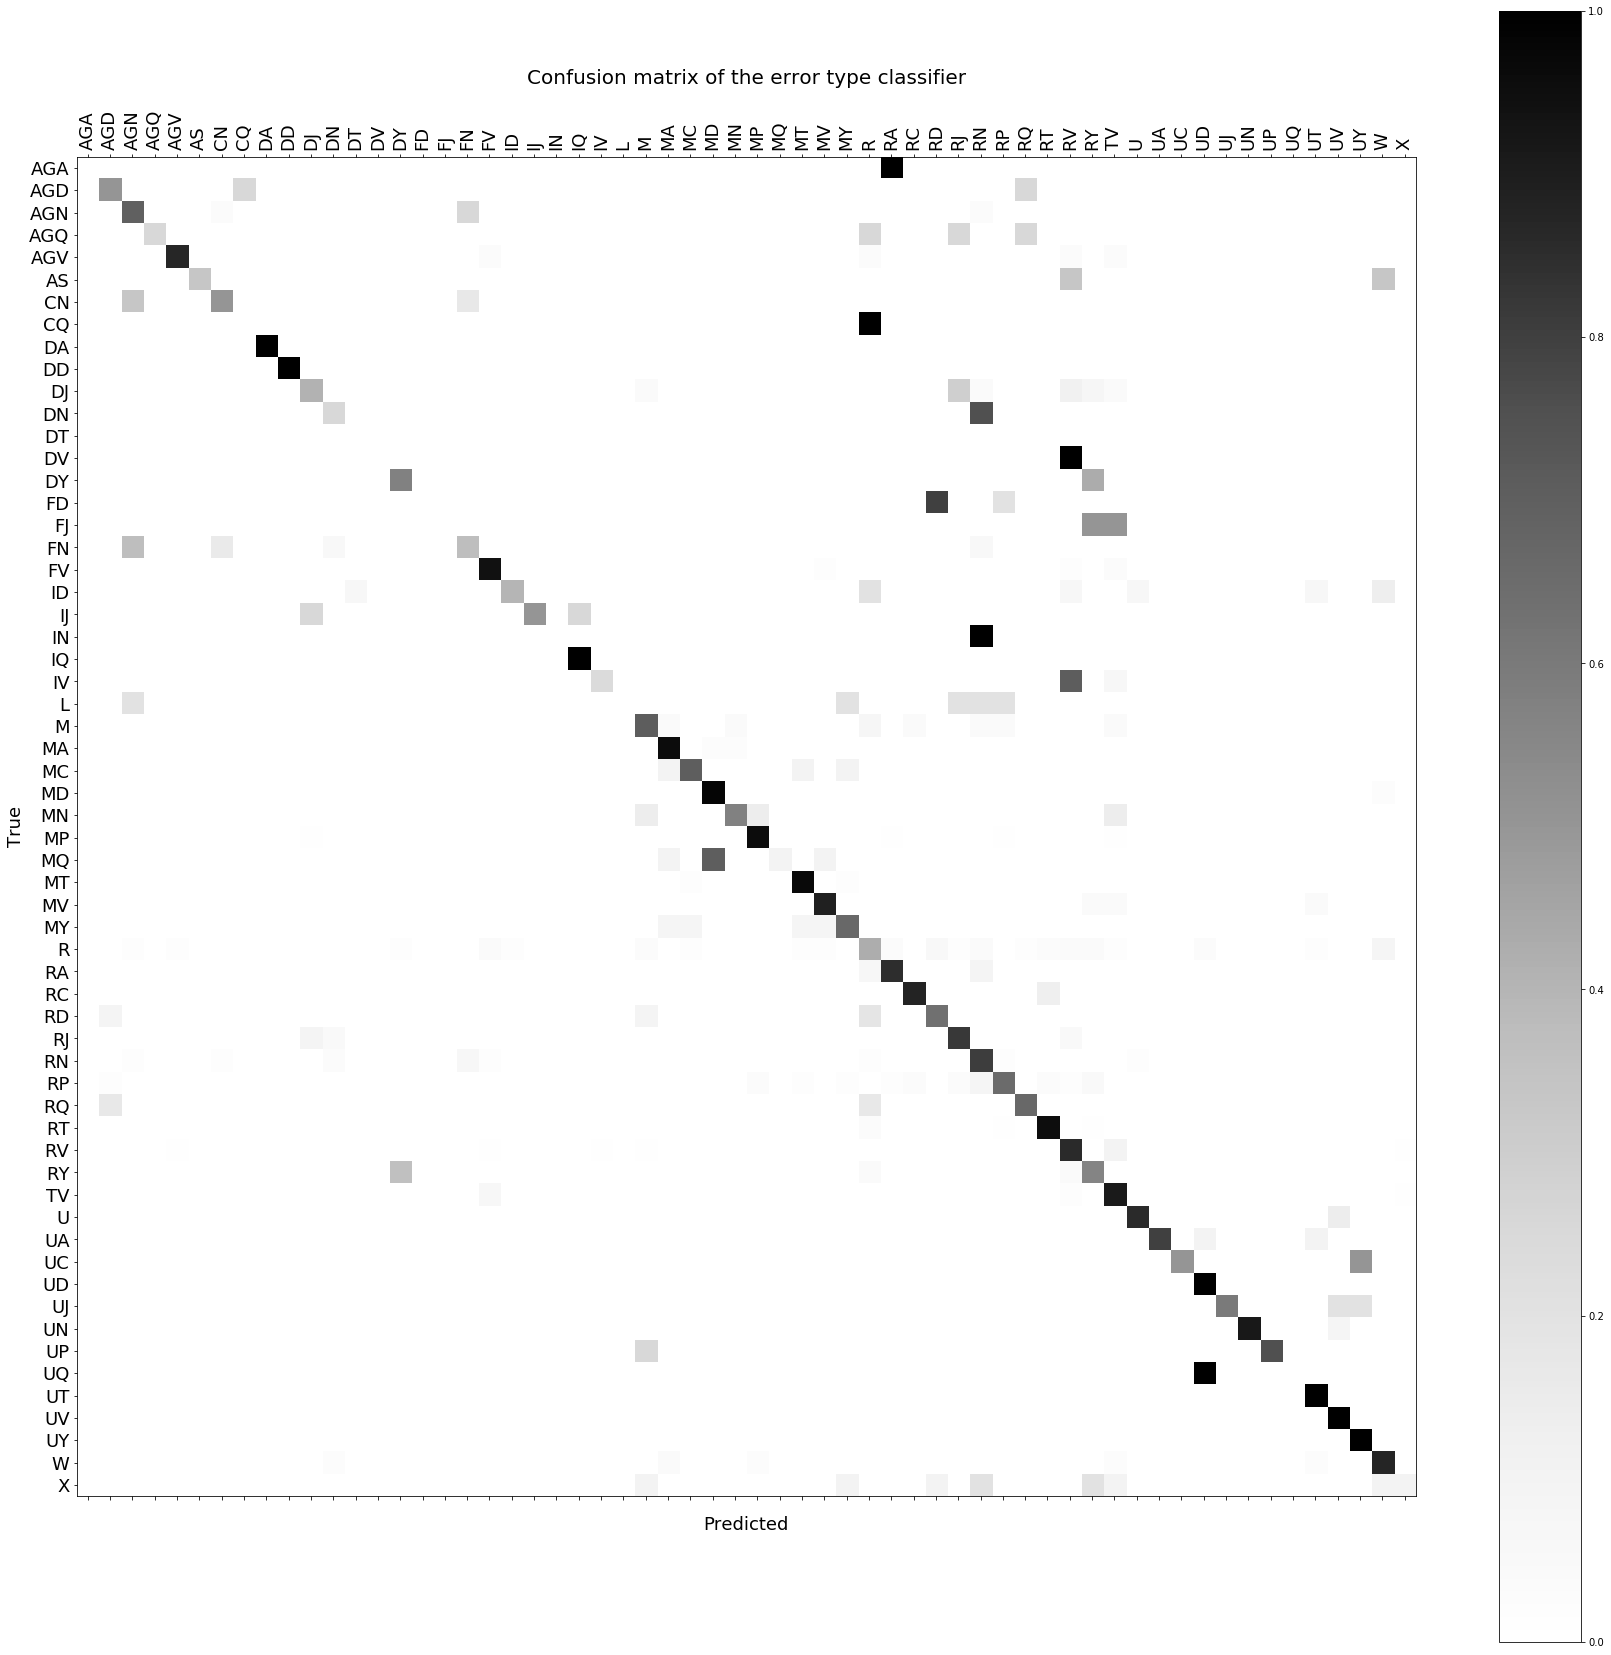

In [27]:
build_matrix(real_y, predicted_y) #Spanish

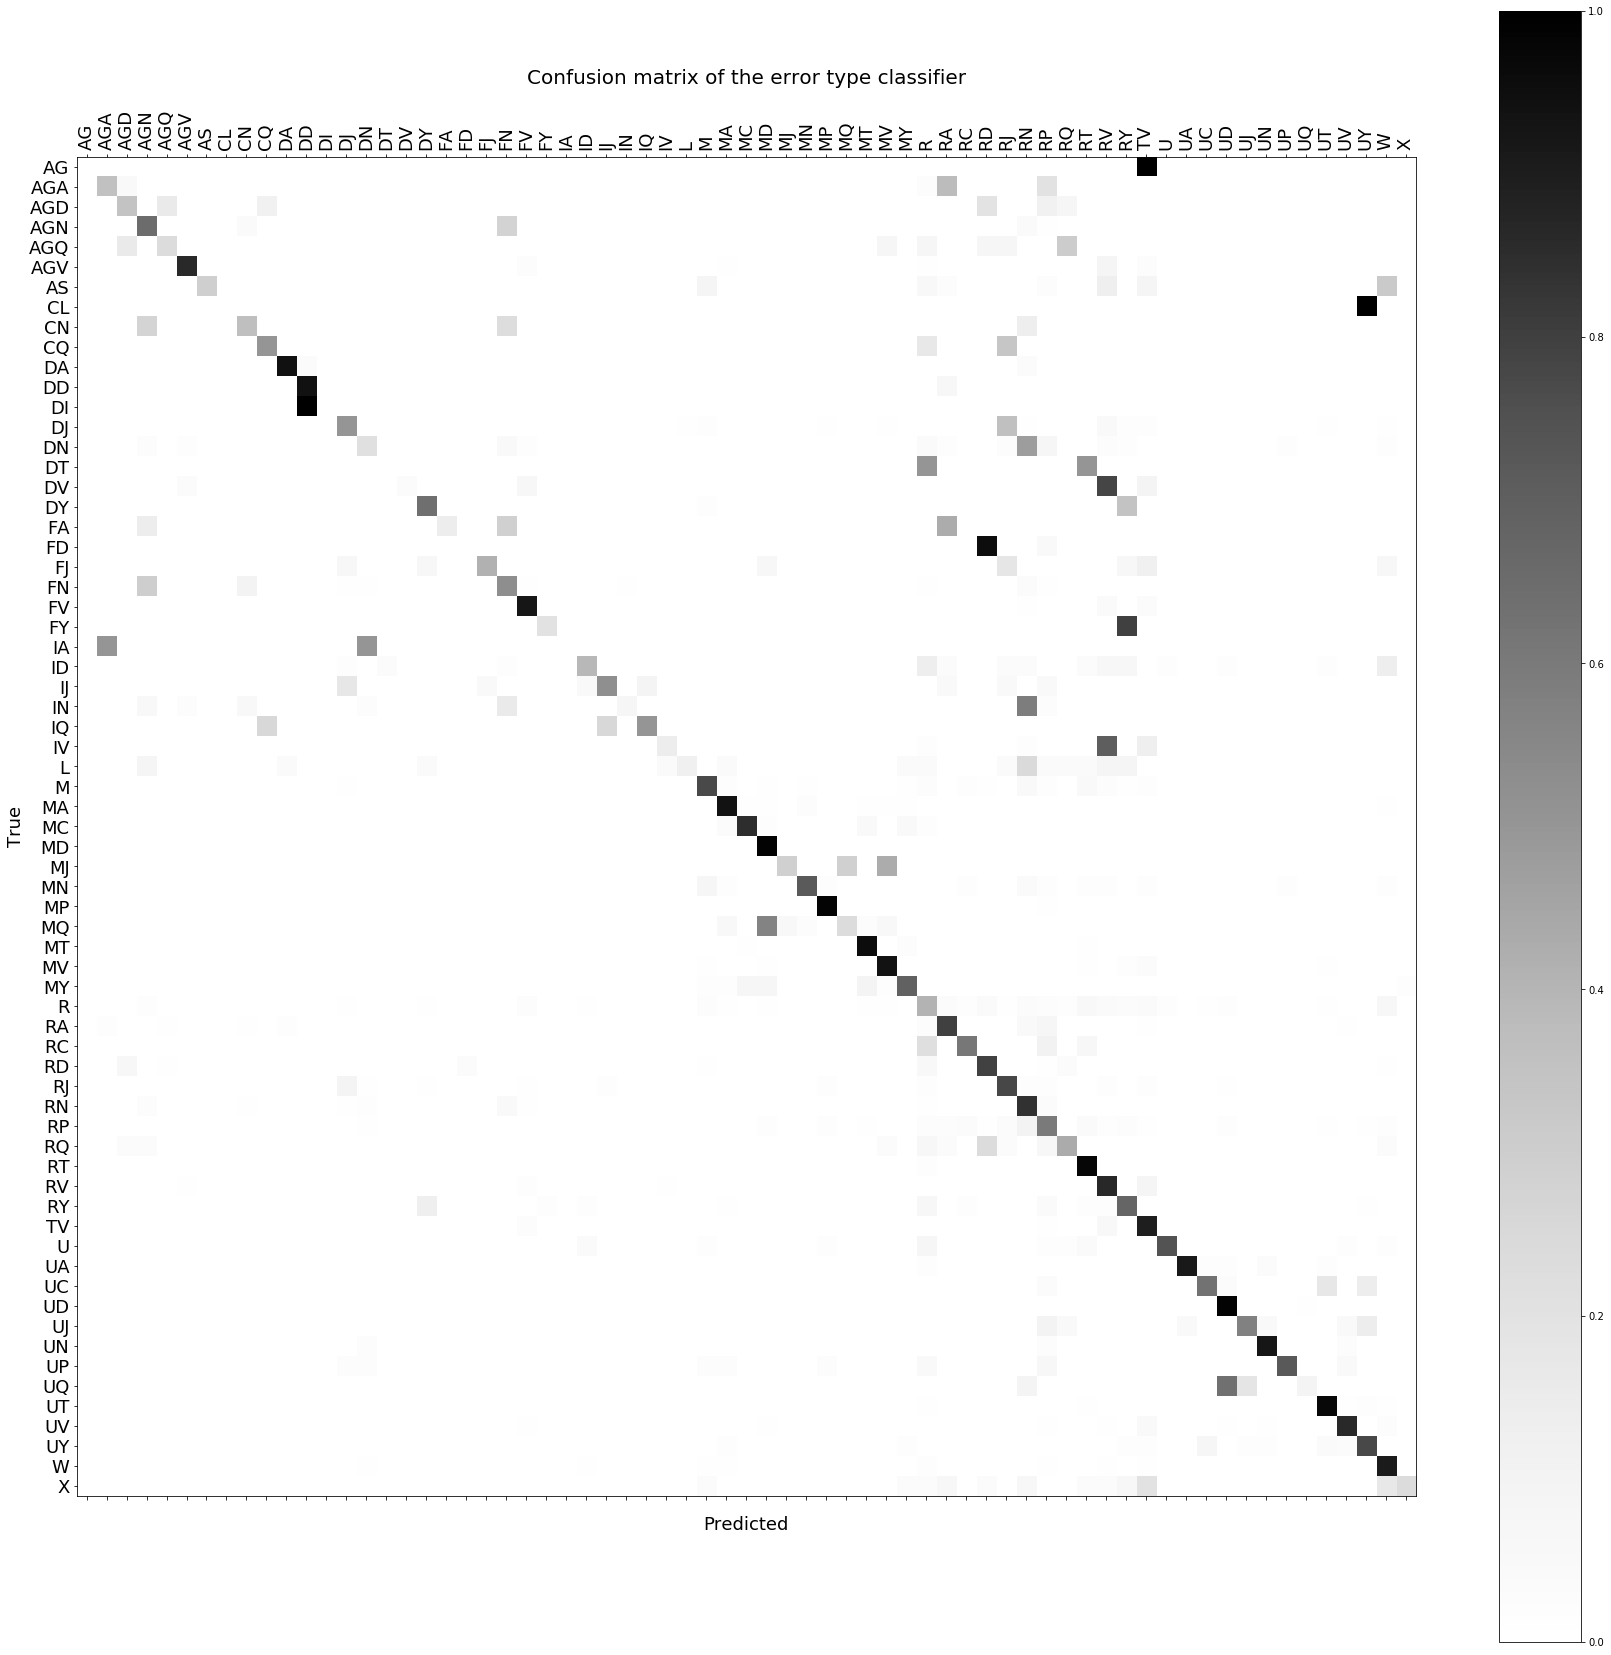

In [28]:
build_matrix(y_test, predictions)

In [29]:
importances = pd.DataFrame({'feature': list(fit_data), 'feature_importance': clf.feature_importances_})
importances = importances.set_index('feature')

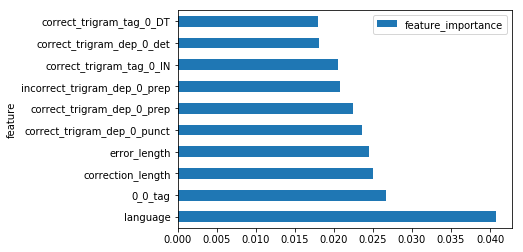

In [30]:
importances = importances.sort_values(by=['feature_importance'], ascending=False)
top_10 = importances[:10]
top_10.plot(kind='barh')